In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import warnings

/tmp/ipython-input-1608089160.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers_list, start=start, progress=False)
/tmp/ipython-input-1608089160.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data.fillna(method='ffill', inplace=True)


Study data is ready.

--- Starting 3D Volatility Return Surface Study ---
Effective study period: 2022-03-30 to 2025-10-27

Generating 3D plot...


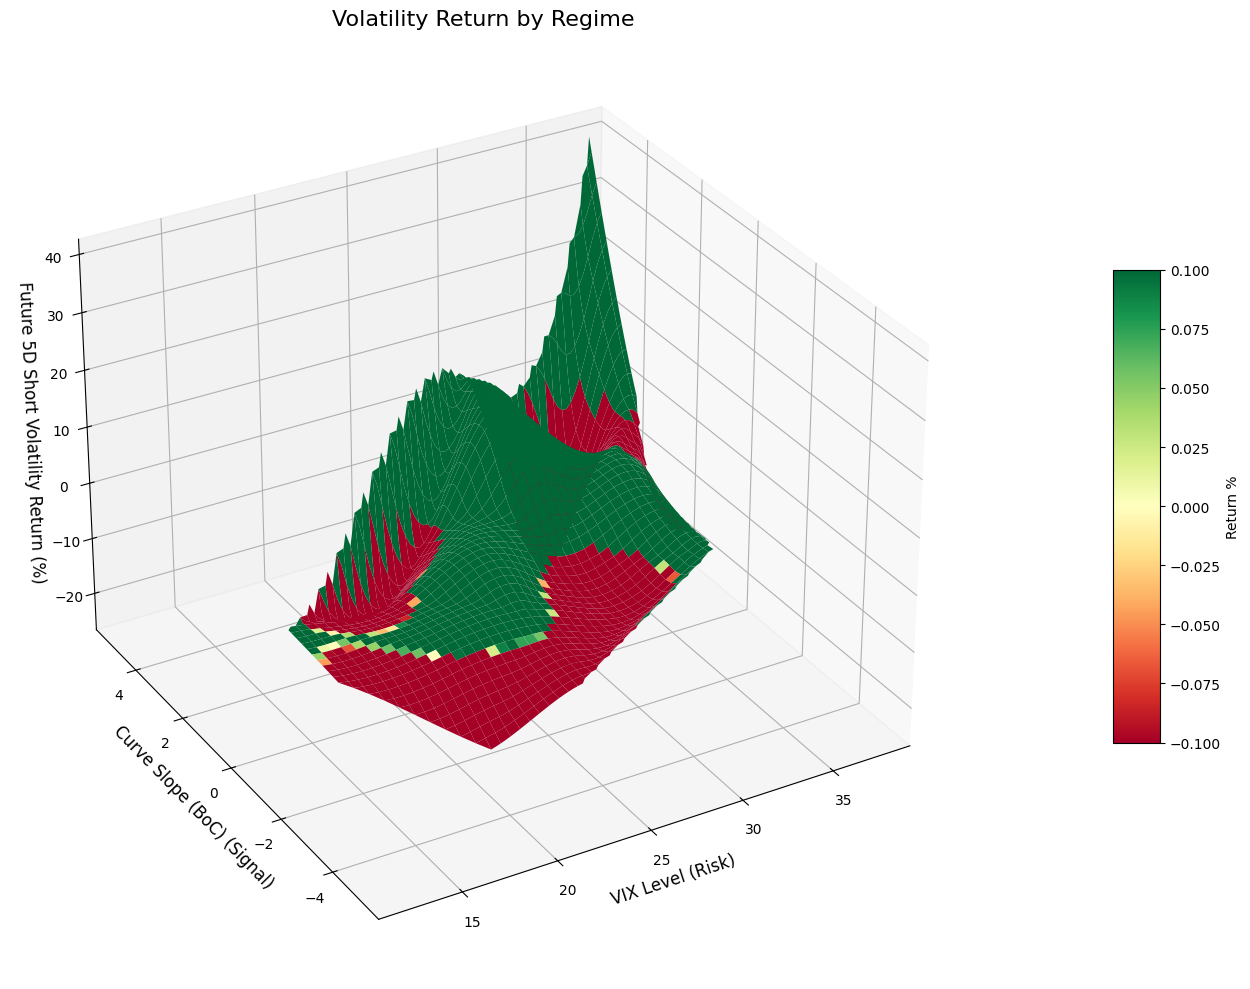

In [ ]:
# --- FUNCTION: Download Data for the Study ---
def load_data_for_study(tickers_list, start="2018-01-01"):
    """
    Downloads study data (VIX, VIX3M, SVIX).
    """
    print("\nDownloading data for 3D Surface Study...")
    try:
        data = yf.download(tickers_list, start=start, progress=False)
        if data.empty:
            print("CRITICAL ERROR: No data downloaded.")
            return pd.DataFrame()
    except Exception as e:
        print(f"CRITICAL ERROR during download: {e}")
        return pd.DataFrame()

    # Fill missing OHLC data for index tickers
    index_tickers = [t for t in tickers_list if t.startswith('^')]
    for ticker in index_tickers:
        if ('Close', ticker) not in data.columns: continue
        if ('Open', ticker) not in data.columns: data[('Open', ticker)] = data[('Close', ticker)]
        if ('High', ticker) not in data.columns: data[('High', ticker)] = data[('Close', ticker)]
        if ('Low', ticker) not in data.columns: data[('Low', ticker)] = data[('Close', ticker)]
        if ('Volume', ticker) not in data.columns: data[('Volume', ticker)] = np.nan

    # Flatten multi-index columns
    data.sort_index(axis=1, level=[1, 0], inplace=True)
    new_cols = []
    for col in data.columns:
        level1, level0 = col
        ticker_name = level0.replace('^', '')
        metric_name = level1.lower().replace(' ', '_')
        new_cols.append(f"{ticker_name}_{metric_name}")
    data.columns = new_cols

    all_data = data.copy()
    all_data.fillna(method='ffill', inplace=True)

    # Drop rows where essential data is missing
    core_signals = ['VIX_close', 'VIX3M_close', 'SVIX_close']
    all_data.dropna(subset=core_signals, inplace=True)

    print("Study data is ready.")
    return all_data

# --- STUDY EXECUTION ---

TICKERS_LIST = ["^VIX", "^VIX3M", "SVIX"]
df_study = load_data_for_study(TICKERS_LIST, start="2018-01-01")

if df_study.empty:
    print("\nCRITICAL ERROR: Insufficient data for the study (SVIX not found?).")
else:
    print(f"\n--- Starting 3D Volatility Return Surface Study ---")

    # 1. Define X, Y, and Z variables
    df_study['VIX_Level'] = df_study['VIX_close']
    df_study['BoC'] = df_study['VIX_close'] - df_study['VIX3M_close']
    df_study['SVIX_Fwd_Ret_5D'] = df_study['SVIX_close'].pct_change(5).shift(-5)

    df_study.dropna(subset=['VIX_Level', 'BoC', 'SVIX_Fwd_Ret_5D'], inplace=True)

    print(f"Effective study period: {df_study.index.min().date()} to {df_study.index.max().date()}")

    # 2. Bin the data
    vix_bins_edges = [10, 15, 20, 25, 30, 35, 40]
    vix_bin_centers = [(vix_bins_edges[i] + vix_bins_edges[i+1]) / 2 for i in range(len(vix_bins_edges)-1)]
    df_study['VIX_Bin'] = pd.cut(df_study['VIX_Level'], bins=vix_bins_edges, labels=vix_bin_centers, right=False)

    boc_bins_edges = [-6, -4, -2, 0, 2, 4, 6]
    boc_bin_centers = [(boc_bins_edges[i] + boc_bins_edges[i+1]) / 2 for i in range(len(boc_bins_edges)-1)]
    df_study['BoC_Bin'] = pd.cut(df_study['BoC'], bins=boc_bins_edges, labels=boc_bin_centers, right=False)

    # Aggregate data to get surface points
    surface_data = df_study.groupby(['BoC_Bin', 'VIX_Bin'], observed=True)['SVIX_Fwd_Ret_5D'].mean().reset_index()
    surface_data['SVIX_Fwd_Ret_5D'] *= 100 # As percentage

    # Extract points (X, Y, Z) for interpolation
    points_x = surface_data['VIX_Bin'].astype(float)
    points_y = surface_data['BoC_Bin'].astype(float)
    points_z = surface_data['SVIX_Fwd_Ret_5D'].astype(float)

    # 3. Interpolate for a continuous grid
    grid_x, grid_y = np.mgrid[min(points_x):max(points_x):100j, min(points_y):max(points_y):100j]
    grid_z = griddata((points_x, points_y), points_z, (grid_x, grid_y), method='cubic')

    # 4. Generate the 3D Plot
    print("\nGenerating 3D plot...")

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create the 3D surface
    surf = ax.plot_surface(
        grid_x, grid_y, grid_z,
        cmap='RdYlGn',         # Red-Yellow-Green colormap
        edgecolor='none',
        vmin=grid_z.min(),
        vmax=grid_z.max()
    )

    # Labels and Title
    ax.set_xlabel('VIX Level (Risk)', fontsize=12)
    ax.set_ylabel('Curve Slope (BoC) (Signal)', fontsize=12)
    ax.set_zlabel('Future 5D Short Volatility Return (%)', fontsize=12)
    ax.set_title('Volatility Return by Regime', fontsize=16)

    # Add color bar
    fig.colorbar(surf, shrink=0.5, aspect=10, pad=0.1).set_label('Return %')

    # Set initial viewing angle
    ax.view_init(elev=30, azim=-120)

    plt.tight_layout()
    plt.show()

In [ ]:
from matplotlib.colors import LightSource
import matplotlib.colors as mcolors
plt.style.use('seaborn-v0_8-whitegrid')


Starting data download for Advanced A/B Study...


/tmp/ipython-input-2614933804.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers_list, start=start, progress=False)
/tmp/ipython-input-2614933804.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data.fillna(method='ffill', inplace=True)


Study data is ready.

--- Starting Advanced A/B Study ---
Effective study period: from 2022-04-13 to 2025-10-27
Days with Positive Premium (eVRP > 0): 729
Days with Negative Premium (eVRP <= 0): 159
Unified color range (Z-Axis): -33.63% to 41.21%
Unified Z-Axis limits: (-38.62831730372755, 46.21052591424239)

Generating Plot A (Positive Premium)...
Saved plot_A_positive_premium.png

Generating Plot B (Negative Premium)...
Saved plot_B_negative_premium.png


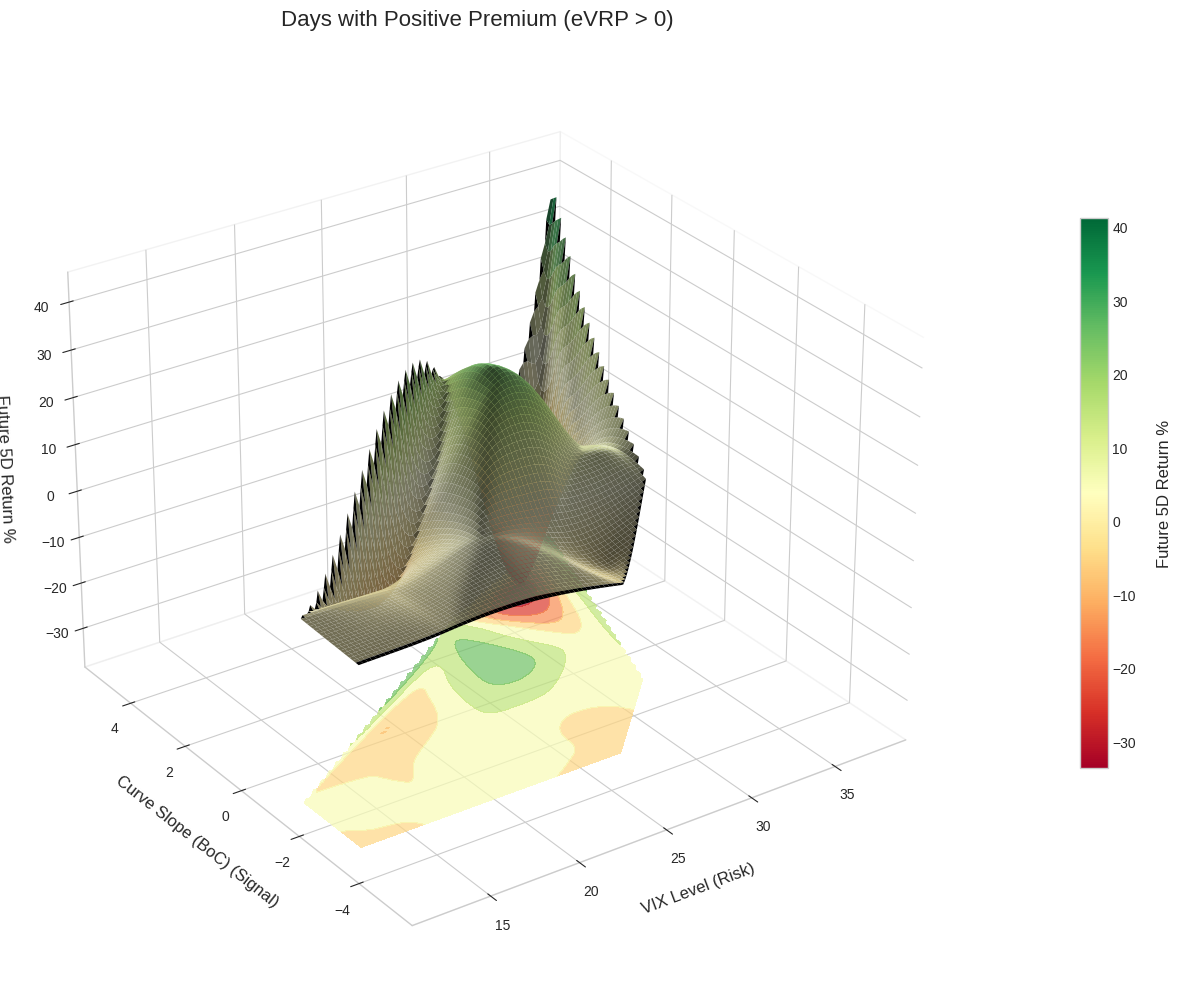

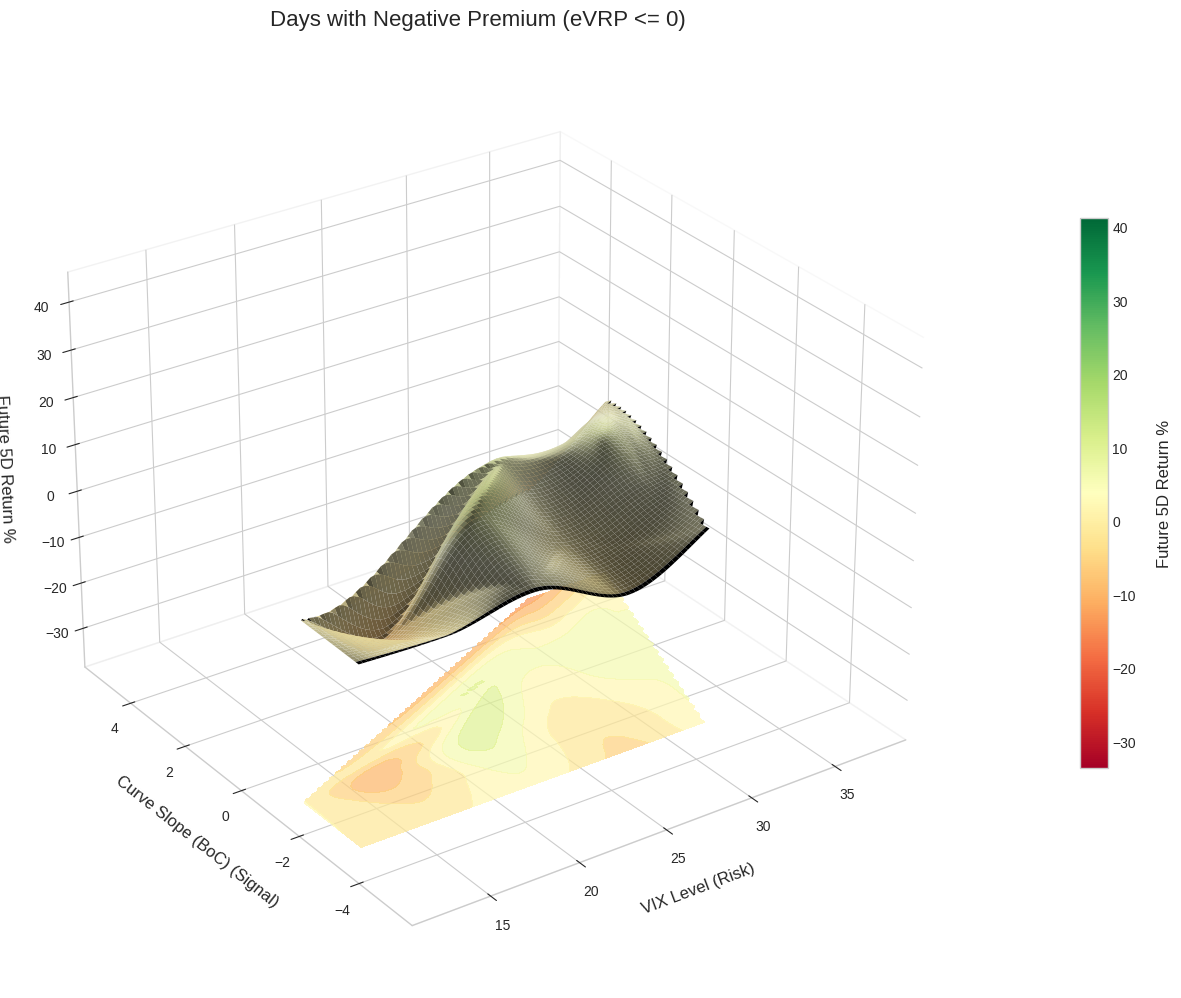

In [ ]:
# FUNCTION: Download Data
def load_data_for_study(tickers_list, start="2018-01-01"):
    """
    Downloads data for the advanced A/B test study (VIX, VIX3M, SVIX, SPY).
    """
    print("\nStarting data download for Advanced A/B Study...")
    try:
        data = yf.download(tickers_list, start=start, progress=False)
        if data.empty:
            print("CRITICAL ERROR: No data downloaded.")
            return pd.DataFrame()
    except Exception as e:
        print(f"CRITICAL ERROR during download: {e}")
        return pd.DataFrame()

    index_tickers = [t for t in tickers_list if t.startswith('^')]
    for ticker in index_tickers:
        if ('Close', ticker) not in data.columns: continue
        if ('Open', ticker) not in data.columns: data[('Open', ticker)] = data[('Close', ticker)]
        if ('High', ticker) not in data.columns: data[('High', ticker)] = data[('Close', ticker)]
        if ('Low', ticker) not in data.columns: data[('Low', ticker)] = data[('Close', ticker)]
        if ('Volume', ticker) not in data.columns: data[('Volume', ticker)] = np.nan
    data.sort_index(axis=1, level=[1, 0], inplace=True)
    new_cols = []
    for col in data.columns:
        level1, level0 = col
        ticker_name = level0.replace('^', '')
        metric_name = level1.lower().replace(' ', '_')
        new_cols.append(f"{ticker_name}_{metric_name}")
    data.columns = new_cols
    all_data = data.copy()
    all_data.fillna(method='ffill', inplace=True)
    core_signals = ['VIX_close', 'VIX3M_close', 'SVIX_close', 'SPY_close']
    all_data.dropna(subset=core_signals, inplace=True)
    print("Study data is ready.")
    return all_data

#  HELPER FUNCTION: Binning
vix_bins_edges = [10, 15, 20, 25, 30, 35, 40]
vix_bin_centers = [(vix_bins_edges[i] + vix_bins_edges[i+1]) / 2 for i in range(len(vix_bins_edges)-1)]
boc_bins_edges = [-6, -4, -2, 0, 2, 4, 6]
boc_bin_centers = [(boc_bins_edges[i] + boc_bins_edges[i+1]) / 2 for i in range(len(boc_bins_edges)-1)]

def bin_data(df):
    """Applies the default bins to the DataFrame."""
    df_binned = df.copy()
    df_binned['VIX_Bin'] = pd.cut(df_binned['VIX_Level'], bins=vix_bins_edges, labels=vix_bin_centers, right=False)
    df_binned['BoC_Bin'] = pd.cut(df_binned['BoC'], bins=boc_bins_edges, labels=boc_bin_centers, right=False)
    return df_binned

#  HELPER FUNCTION: Advanced 3D Plot
def plot_3d_surface(ax, df_input, title, vmin, vmax, z_limits):
    """
    Plots a 3D surface with:
    1. Unified Z-limits (z_limits)
    2. 2D contour map on the "floor"
    3. Clean background and lighting
    """
    # 1. Bin and aggregate data
    df_binned = bin_data(df_input)
    surface_data = df_binned.groupby(['BoC_Bin', 'VIX_Bin'], observed=True)['SVIX_Fwd_Ret_5D'].mean().reset_index()
    surface_data['SVIX_Fwd_Ret_5D'] *= 100

    if surface_data.empty or len(surface_data) < 4:
        print(f"WARNING: Insufficient data to plot '{title}'. Skipping...")
        ax.text2D(0.5, 0.5, "Insufficient data for this plot",
                  horizontalalignment='center', verticalalignment='center',
                  transform=ax.transAxes, color='red', fontsize=14)
        ax.set_title(title, fontsize=16)
        return None

    # 2. Extract points and interpolate
    points_x = surface_data['VIX_Bin'].astype(float)
    points_y = surface_data['BoC_Bin'].astype(float)
    points_z = surface_data['SVIX_Fwd_Ret_5D'].astype(float)

    grid_x, grid_y = np.mgrid[min(vix_bin_centers):max(vix_bin_centers):100j,
                              min(boc_bin_centers):max(boc_bin_centers):100j]

    grid_z = griddata((points_x, points_y), points_z, (grid_x, grid_y), method='cubic')

    # 3. Handle lighting
    ls = LightSource(azdeg=315, altdeg=45)
    cmap = plt.get_cmap('RdYlGn')
    rgb = ls.shade(grid_z, cmap=cmap, vmin=vmin, vmax=vmax, vert_exag=0.1, blend_mode='soft')

    # 4. Plot the 3D surface
    surf = ax.plot_surface(
        grid_x, grid_y, grid_z,
        rstride=1, cstride=1,
        facecolors=rgb,
        edgecolor='none',
        antialiased=True,
        vmin=vmin,
        vmax=vmax
    )

    # 5. Add contour plot on the "floor"
    cset = ax.contourf(
        grid_x, grid_y, grid_z,
        zdir='z',
        offset=z_limits[0], # Plot at the bottom Z-limit
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        alpha=0.7
    )

    # 6. Labels and Title
    ax.set_xlabel('VIX Level (Risk)', fontsize=12, labelpad=10)
    ax.set_ylabel('Curve Slope (BoC) (Signal)', fontsize=12, labelpad=10)
    ax.set_zlabel('Future 5D Return %', fontsize=12, labelpad=10)
    ax.set_title(title, fontsize=16, pad=20)

    # 7. Apply global Z limits
    ax.set_zlim(z_limits)

    # 8. View angle
    ax.view_init(elev=28, azim=-125)

    # 9. Clean the background
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(alpha=0.3) # Lighter grid

    return surf

#  ADVANCED A/B STUDY EXECUTION

TICKERS_LIST_ADVANCED = ["^VIX", "^VIX3M", "SVIX", "SPY"]
df_study_advanced = load_data_for_study(TICKERS_LIST_ADVANCED, start="2018-01-01")

if df_study_advanced.empty:
    print("\nCRITICAL ERROR: Insufficient data for the advanced study.")
else:
    print(f"\n--- Starting Advanced A/B Study ---")

    # 2. Define variables
    df_study_advanced['VIX_Level'] = df_study_advanced['VIX_close']
    df_study_advanced['BoC'] = df_study_advanced['VIX_close'] - df_study_advanced['VIX3M_close']
    df_study_advanced['SVIX_Fwd_Ret_5D'] = df_study_advanced['SVIX_close'].pct_change(5).shift(-5)

    # 3. Define the filter signal (eVRP)
    df_study_advanced['SPY_ret'] = df_study_advanced['SPY_close'].pct_change()
    df_study_advanced['eRV_10d'] = df_study_advanced['SPY_ret'].rolling(10).std() * np.sqrt(252) * 100
    df_study_advanced['eVRP'] = df_study_advanced['VIX_close'] - df_study_advanced['eRV_10d']

    core_cols = ['VIX_Level', 'BoC', 'SVIX_Fwd_Ret_5D', 'eVRP']
    df_study_advanced.dropna(subset=core_cols, inplace=True)
    print(f"Effective study period: from {df_study_advanced.index.min().date()} to {df_study_advanced.index.max().date()}")

    # 4. Split the data
    df_positive_vrp = df_study_advanced[df_study_advanced['eVRP'] > 0].copy()
    df_negative_vrp = df_study_advanced[df_study_advanced['eVRP'] <= 0].copy()
    print(f"Days with Positive Premium (eVRP > 0): {len(df_positive_vrp)}")
    print(f"Days with Negative Premium (eVRP <= 0): {len(df_negative_vrp)}")

    # 5. Calculate global VMIN/VMAX and Z limits
    data_pos_agg = bin_data(df_positive_vrp).groupby(['BoC_Bin', 'VIX_Bin'], observed=True)['SVIX_Fwd_Ret_5D'].mean() * 100
    data_neg_agg = bin_data(df_negative_vrp).groupby(['BoC_Bin', 'VIX_Bin'], observed=True)['SVIX_Fwd_Ret_5D'].mean() * 100

    vmin = min(data_pos_agg.min(), data_neg_agg.min())
    vmax = max(data_pos_agg.max(), data_neg_agg.max())
    print(f"Unified color range (Z-Axis): {vmin:.2f}% to {vmax:.2f}%")

    z_min_global = vmin - 5
    z_max_global = vmax + 5
    z_limits = (z_min_global, z_max_global)
    print(f"Unified Z-Axis limits: {z_limits}")

    # 6. Generate Plot A
    print("\nGenerating Plot A (Positive Premium)...")
    fig1 = plt.figure(figsize=(14, 11)) # Create Figure 1

    ax1 = fig1.add_subplot(1, 1, 1, projection='3d') # Add a 1x1 subplot
    surf1 = plot_3d_surface(ax1, df_positive_vrp,
                            "Days with Positive Premium (eVRP > 0)",
                            vmin, vmax, z_limits)

    # Add colorbar for Plot A
    cmap = plt.get_cmap('RdYlGn')
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cax1 = fig1.add_axes([0.88, 0.25, 0.02, 0.5])
    cbar1 = fig1.colorbar(sm, cax=cax1, orientation='vertical')
    cbar1.set_label('Future 5D Return %', fontsize=12, labelpad=15)

    plt.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.05)

    fig1.savefig("plot_A_positive_premium.png", dpi=300, bbox_inches='tight')
    print("Saved plot_A_positive_premium.png")

    # 7. Generate Plot B
    print("\nGenerating Plot B (Negative Premium)...")
    fig2 = plt.figure(figsize=(14, 11)) # Create Figure 2

    ax2 = fig2.add_subplot(1, 1, 1, projection='3d') # Add a 1x1 subplot
    surf2 = plot_3d_surface(ax2, df_negative_vrp,
                            "Days with Negative Premium (eVRP <= 0)",
                            vmin, vmax, z_limits)

    # Add colorbar for Plot B (using same limits)
    cax2 = fig2.add_axes([0.88, 0.25, 0.02, 0.5])
    cbar2 = fig2.colorbar(sm, cax=cax2, orientation='vertical')
    cbar2.set_label('Future 5D Return %', fontsize=12, labelpad=15)

    plt.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.05)

    fig2.savefig("plot_B_negative_premium.png", dpi=300, bbox_inches='tight')
    print("Saved plot_B_negative_premium.png")

    plt.show()